In [29]:
import os

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pruned_ft_df = pd.read_json(
    "/gscratch/cse/clin25/diffusion-attr/seed42/artbench_post_impressionism/pruned_ft.jsonl",
    lines=True,
)
num_steps_per_epoch = 79
n_samples = 50

In [3]:
pruned_ft_df["ratio"] = (
    pruned_ft_df["exp_name"]
    .str.split("/", expand=True)[4]
    .str.split("=", expand=True)[1]
    .astype(float)
)
pruned_ft_df["steps"] = (
    pruned_ft_df["exp_name"]
    .str.split("/", expand=True)[5]
    .str.split("=", expand=True)[1]
    .astype(int)
)
pruned_ft_df["epochs"] = pruned_ft_df["steps"] / num_steps_per_epoch

ratio_list = pruned_ft_df["ratio"].unique().tolist()
epochs_list = pruned_ft_df["epochs"].unique().tolist()
ratio_list = sorted(ratio_list)
epochs_list = sorted(epochs_list)

In [4]:
ssim_cols = [f"generated_image_{i}_ssim" for i in range(n_samples)]

In [13]:
ratio_ssim_dict = {}
for ratio in ratio_list:
    df = pruned_ft_df[pruned_ft_df["ratio"] == ratio]
    df = df.sort_values("epochs", ascending=True)
    ratio_ssim_dict[ratio] = {
        epochs: df[ssim_cols].mean(axis=1).to_list()[i]
        for i, epochs in enumerate(epochs_list)
    }

In [14]:
optimal_ratio, optimal_epochs = None, None
optimal_ssim = 0
for ratio in ratio_list:
    for epochs in epochs_list:
        ssim = ratio_ssim_dict[ratio][epochs]
        if ssim > optimal_ssim:
            optimal_ssim = ssim
            optimal_ratio = ratio
            optimal_epochs = epochs
print(f"Optimal mean SSIM={optimal_ssim}")
print(f"Optimal ratio={optimal_ratio}")
print(f"Optimal epochs={optimal_epochs}")

Optimal mean SSIM=0.6787904148761403
Optimal ratio=0.6
Optimal epochs=20.0


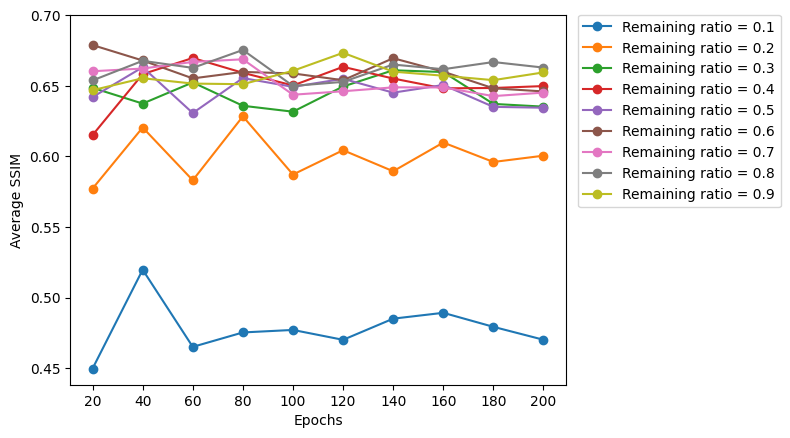

In [28]:
for ratio in ratio_list:
    ssim_list = [ratio_ssim_dict[ratio][epochs] for epochs in epochs_list]
    plt.plot(epochs_list, ssim_list, marker="o", label=f"Remaining ratio = {ratio}")
plt.xticks(epochs_list)
plt.yticks([0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
plt.xlabel("Epochs")
plt.ylabel("Average SSIM")
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.show()

In [41]:
parent_dir = "/gscratch/cse/clin25/diffusion-attr/seed42/artbench_post_impressionism"
full_time_df = pd.read_csv(
    os.path.join(
        parent_dir,
        "retrain/models/full/",
        "time.csv",
    )
)
avg_full_time = full_time_df["time"].mean()

In [50]:
ratio_time_list = []
for ratio in ratio_list:
    time_df = pd.read_csv(
        os.path.join(
            parent_dir,
            f"pruned_ft_ratio={ratio}/models/full",
            "time.csv",
        )
    )
    avg_epoch_time = time_df["time"].mean()
    ratio_time_list.append(avg_full_time / avg_epoch_time)

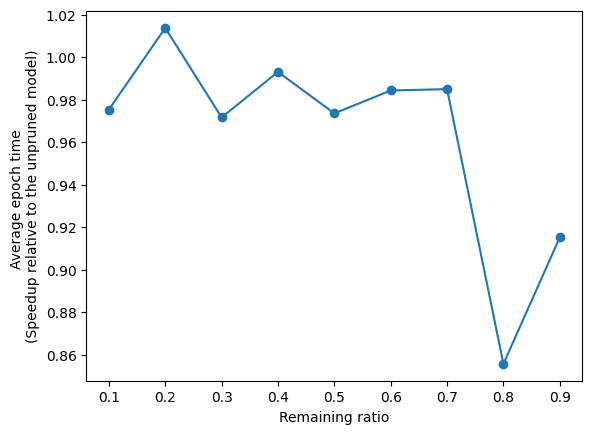

In [57]:
plt.plot(ratio_list, ratio_time_list, marker="o")
plt.xlabel("Remaining ratio")
plt.ylabel("Average epoch time \n(Speedup relative to the unpruned model)")
plt.show()